In [3]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

def add_phase_column(evs):
    """Add phase column to events DataFrame"""
    evs["phase"] = 1
    new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
    for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
        list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
        if list_evs['trial'].unique()[0] != -999:
            list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
                # find indexes of encoding start and end
                rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
                if not rec_start_indices.empty:
                    rec_start_index = rec_start_indices[0]
                    start_time = list_evs.loc[rec_start_index]['eegoffset']
                    # Find the actual start index based on time condition
                    i = 0
                    rec_start_index_found = True
                    actual_start_index = rec_start_index  # Initialize with default
                    
                    while rec_start_index_found:
                        current_idx = rec_start_index + i
                        print(i)
                        # Check bounds for iloc access
                        check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                        if check_time - start_time < 3000:
                            i += 1
                            print(check_time - start_time)
                        else:
                            rec_start_index_found = False
                            actual_start_index = rec_start_index+i
                            print(i)# Get actual index from list_evs
                    rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                    if not rec_end_indices.empty:
                        rec_end_index = rec_end_indices[0]
                        # Now assign to original evs DataFrame using the original indices
                        evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                        print('get one value', actual_start_index,rec_end_index)
    return evs

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the phase column
            evs = add_phase_column(evs)
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                
                # Keep checking subsequent rows until difference >= 3000
                j = i + 1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            
            # Get unique trials for this session
            trials = evs['trial'].unique()
            
            # Loop through each trial
            for trial in trials:
                if trial != -999 and trial >= 0:  # Skip invalid trials   if trial != -999 and trial >= 0:
                   # print(f"    Processing trial: {trial}")
                    
                    # Filter events for this specific trial
                    trial_evs = evs[evs['trial'] == trial]
                    
                    # Filter for intrusions with additional conditions for this trial
                    intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                                                (trial_evs['type'] == 'REC_WORD') & 
                                                (trial_evs['phase'] == 'retrieval')]
                    none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                                     (trial_evs['type'] == 'REC_WORD') & 
                                                     (trial_evs['phase'] == 'retrieval')]

                    # Count intrusions for each stimulation condition
                    intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
                    intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
                    intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
                    intrusion_count_total = len(intrusion_events)

                    # Count none intrusions for each stimulation condition
                    none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
                    none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
                    none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
                    none_intrusion_count_total = len(none_intrusion_events)

                    # Store results for this trial
                    trial_result = {
                                'subject': subject,
                                'session': session,
                                'trial': trial,
                                'intrusion_count_3hz': intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'intrusion_count_8hz': intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'intrusion_count_no_stim': intrusion_count_no_stim,
                                'intrusion_count_total': intrusion_count_total,
                                'none_intrusion_count_3hz': none_intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'none_intrusion_count_8hz': none_intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'none_intrusion_count_no_stim': none_intrusion_count_no_stim,
                                'none_intrusion_count_total': none_intrusion_count_total,
                                'relative_intrusion_3hz': intrusion_count_3hz - intrusion_count_no_stim if intrusion_count_3hz != 0 else None, 
                                'relative_intrusion_8hz': intrusion_count_8hz - intrusion_count_no_stim if intrusion_count_8hz != 0 else None,
                                'relative_recall_3hz': none_intrusion_count_3hz - none_intrusion_count_no_stim if none_intrusion_count_3hz != 0 else None,
                                'relative_recall_8hz': none_intrusion_count_8hz - none_intrusion_count_no_stim if none_intrusion_count_8hz != 0 else None,
                            }
                    results.append(trial_result)
                    
                    print(f"      Trial {trial} - Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
            print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY (BY TRIAL)")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {results_df['session'].nunique()}")
    print(f"Total trials processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all trials:")
    print(f"Mean intrusions per trial:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all trials:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
    print(results_df.to_string(index=False))
else:
    print("No results to display. Check for errors in processing.")

Processing subject: FBG490
  Processing session: 0
0
0
1
1
get one value 49 67
0
0
1
1
get one value 155 177
0
0
1
1
get one value 264 282
0
0
1
1
get one value 370 389
0
0
1
1
get one value 474 492
      Trial 0 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
      Trial 1 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 0, Total: 0
      Trial 2 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
      Trial 3 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 0, Total: 0
      Trial 4 - Intrusions - 3Hz: 0, 8Hz: 1, No stim: 1, Total: 2
  Processing session: 1
0
0
1
1
get one value 48 78
0
0
1
1
get one value 164 189
0
0
1
1
get one value 278 299
0
0
1
1
get one value 389 409
0
0
1
1
get one value 496 522
      Trial 0 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
      Trial 1 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 1, Total: 1
      Trial 2 - Intrusions - 3Hz: 0, 8Hz: 1, No stim: 0, Total: 1
      Trial 3 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 1, Total: 1
      Trial 4 - Intrusions - 3Hz: 0


CHANGE vs NO STIMULATION BASELINE
INTRUSION CHANGES:
  3Hz vs No Stim: -0.18
  8Hz vs No Stim: -0.39

CORRECT RECALL CHANGES:
  3Hz vs No Stim: -1.14
  8Hz vs No Stim: -1.52

Plot saved as: efr_courier_simple_analysis.png
Results saved as: efr_courier_results.csv


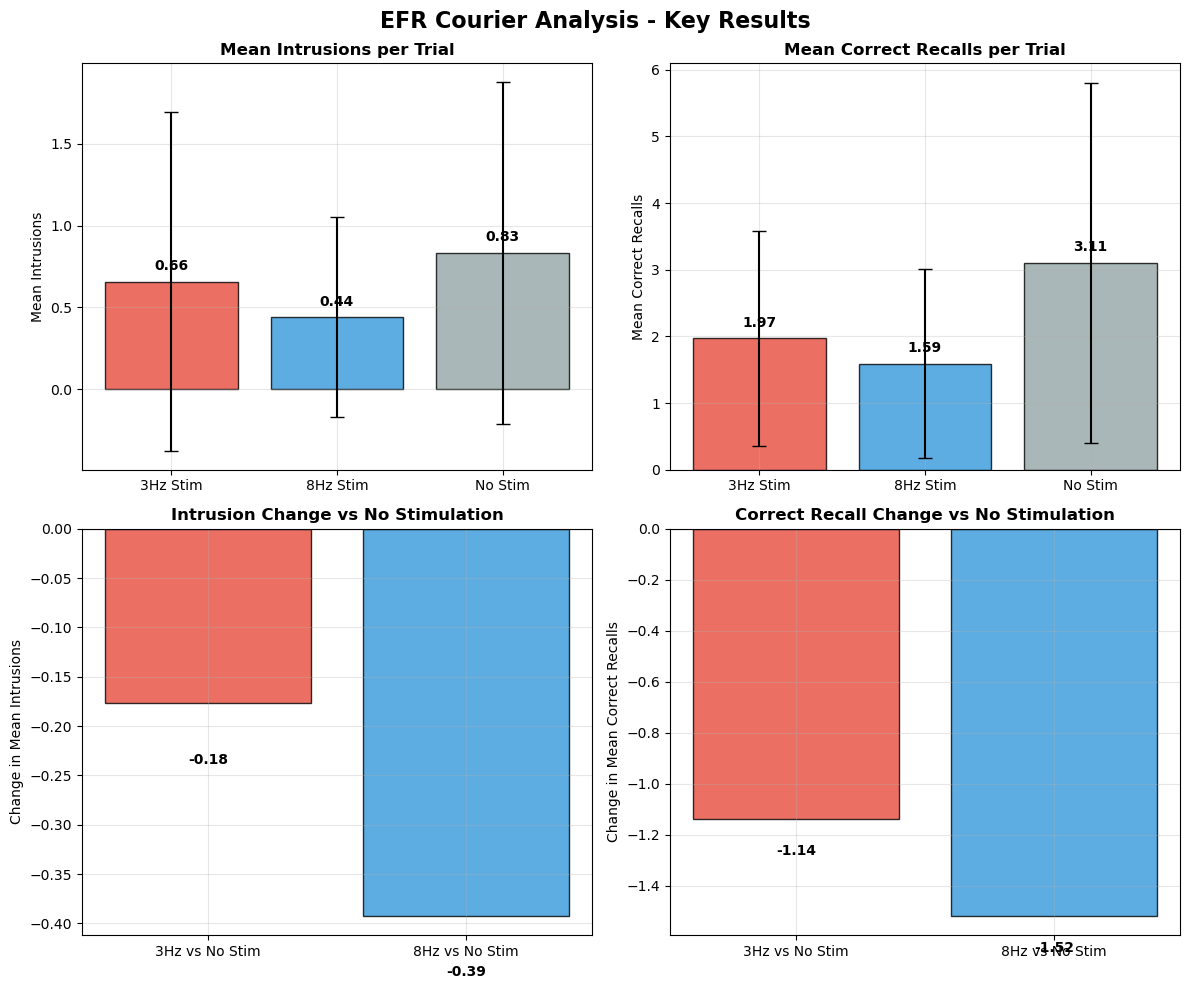


Analysis complete!


In [4]:
# Set up the figure
intrusion_3hz_mean = results_df['intrusion_count_3hz'].dropna().mean()
intrusion_3hz_std = results_df['intrusion_count_3hz'].dropna().std()
intrusion_8hz_mean = results_df['intrusion_count_8hz'].dropna().mean()
intrusion_8hz_std = results_df['intrusion_count_8hz'].dropna().std()
intrusion_no_stim_mean = results_df['intrusion_count_no_stim'].mean()
intrusion_no_stim_std = results_df['intrusion_count_no_stim'].std()

recall_3hz_mean = results_df['none_intrusion_count_3hz'].dropna().mean()
recall_3hz_std = results_df['none_intrusion_count_3hz'].dropna().std()
recall_8hz_mean = results_df['none_intrusion_count_8hz'].dropna().mean()
recall_8hz_std = results_df['none_intrusion_count_8hz'].dropna().std()
recall_no_stim_mean = results_df['none_intrusion_count_no_stim'].mean()
recall_no_stim_std = results_df['none_intrusion_count_no_stim'].std()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('EFR Courier Analysis - Key Results', fontsize=16, fontweight='bold')

# Colors for conditions
colors = ['#e74c3c', '#3498db', '#95a5a6']  # Red, Blue, Gray
condition_labels = ['3Hz Stim', '8Hz Stim', 'No Stim']

# Plot 1: Mean Intrusions per Trial
intrusion_means = [intrusion_3hz_mean, intrusion_8hz_mean, intrusion_no_stim_mean]
intrusion_stds = [intrusion_3hz_std, intrusion_8hz_std, intrusion_no_stim_std]

bars1 = ax1.bar(condition_labels, intrusion_means, yerr=intrusion_stds, 
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Mean Intrusions per Trial', fontweight='bold')
ax1.set_ylabel('Mean Intrusions')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars1, intrusion_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(intrusion_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Mean Correct Recalls per Trial
recall_means = [recall_3hz_mean, recall_8hz_mean, recall_no_stim_mean]
recall_stds = [recall_3hz_std, recall_8hz_std, recall_no_stim_std]

bars2 = ax2.bar(condition_labels, recall_means, yerr=recall_stds,
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Mean Correct Recalls per Trial', fontweight='bold')
ax2.set_ylabel('Mean Correct Recalls')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars2, recall_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Change in Intrusions vs No Stimulation Baseline
intrusion_change_3hz = intrusion_3hz_mean - intrusion_no_stim_mean
intrusion_change_8hz = intrusion_8hz_mean - intrusion_no_stim_mean
intrusion_changes = [intrusion_change_3hz, intrusion_change_8hz]
change_labels = ['3Hz vs No Stim', '8Hz vs No Stim']

bars3 = ax3.bar(change_labels, intrusion_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('Intrusion Change vs No Stimulation', fontweight='bold')
ax3.set_ylabel('Change in Mean Intrusions')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars3, intrusion_changes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, 
             height + 0.05 if height >= 0 else height - 0.05,
             f'{change:.2f}', ha='center', 
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Plot 4: Change in Correct Recalls vs No Stimulation Baseline
recall_change_3hz = recall_3hz_mean - recall_no_stim_mean
recall_change_8hz = recall_8hz_mean - recall_no_stim_mean
recall_changes = [recall_change_3hz, recall_change_8hz]

bars4 = ax4.bar(change_labels, recall_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax4.set_title('Correct Recall Change vs No Stimulation', fontweight='bold')
ax4.set_ylabel('Change in Mean Correct Recalls')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars4, recall_changes):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2,
             height + 0.1 if height >= 0 else height - 0.1,
             f'{change:.2f}', ha='center',
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Adjust layout and show
plt.tight_layout()

# Print change statistics
print("\n" + "="*50)
print("CHANGE vs NO STIMULATION BASELINE")
print("="*50)
print("INTRUSION CHANGES:")
print(f"  3Hz vs No Stim: {intrusion_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {intrusion_change_8hz:.2f}")
print()
print("CORRECT RECALL CHANGES:")
print(f"  3Hz vs No Stim: {recall_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {recall_change_8hz:.2f}")

# Save the plot
plt.savefig('efr_courier_simple_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as: efr_courier_simple_analysis.png")

# Save results to CSV
results_df.to_csv('efr_courier_results.csv', index=False)
print(f"Results saved as: efr_courier_results.csv")

plt.show()

print("\nAnalysis complete!")


SUBJECT-LEVEL ANALYSIS

INTRUSION MEANS BY SUBJECT:
Subject FBG490:
  3Hz: 0.00
  8Hz: 0.33
  No Stim: 1.40
Subject FBG491:
  3Hz: 0.83
  8Hz: 0.60
  No Stim: 2.00
Subject R1620J:
  3Hz: 1.00
  8Hz: 1.00
  No Stim: 0.20
Subject R1653J:
  3Hz: 0.14
  8Hz: 0.43
  No Stim: 0.29
Subject R1693J:
  3Hz: 2.00
  8Hz: 0.33
  No Stim: 0.67
Subject R1709J:
  3Hz: 0.33
  8Hz: 0.00
  No Stim: 0.29
Subject R1724J:
  3Hz: 2.00
  8Hz: 0.50
  No Stim: 0.50

OVERALL MEANS:
  3Hz: 0.66
  8Hz: 0.44
  No Stim: 0.83

CORRECT RECALL MEANS BY SUBJECT:
Subject FBG490:
  3Hz: 1.67
  8Hz: 2.11
  No Stim: 6.40
Subject FBG491:
  3Hz: 1.50
  8Hz: 1.40
  No Stim: 4.70
Subject R1620J:
  3Hz: 3.00
  8Hz: 1.25
  No Stim: 2.60
Subject R1653J:
  3Hz: 1.29
  8Hz: 1.57
  No Stim: 1.07
Subject R1693J:
  3Hz: 2.00
  8Hz: 0.33
  No Stim: 0.17
Subject R1709J:
  3Hz: 3.67
  8Hz: 1.25
  No Stim: 2.14
Subject R1724J:
  3Hz: 1.00
  8Hz: 3.00
  No Stim: 1.25

OVERALL MEANS:
  3Hz: 1.97
  8Hz: 1.59
  No Stim: 3.11

CHANGE SCORES BY

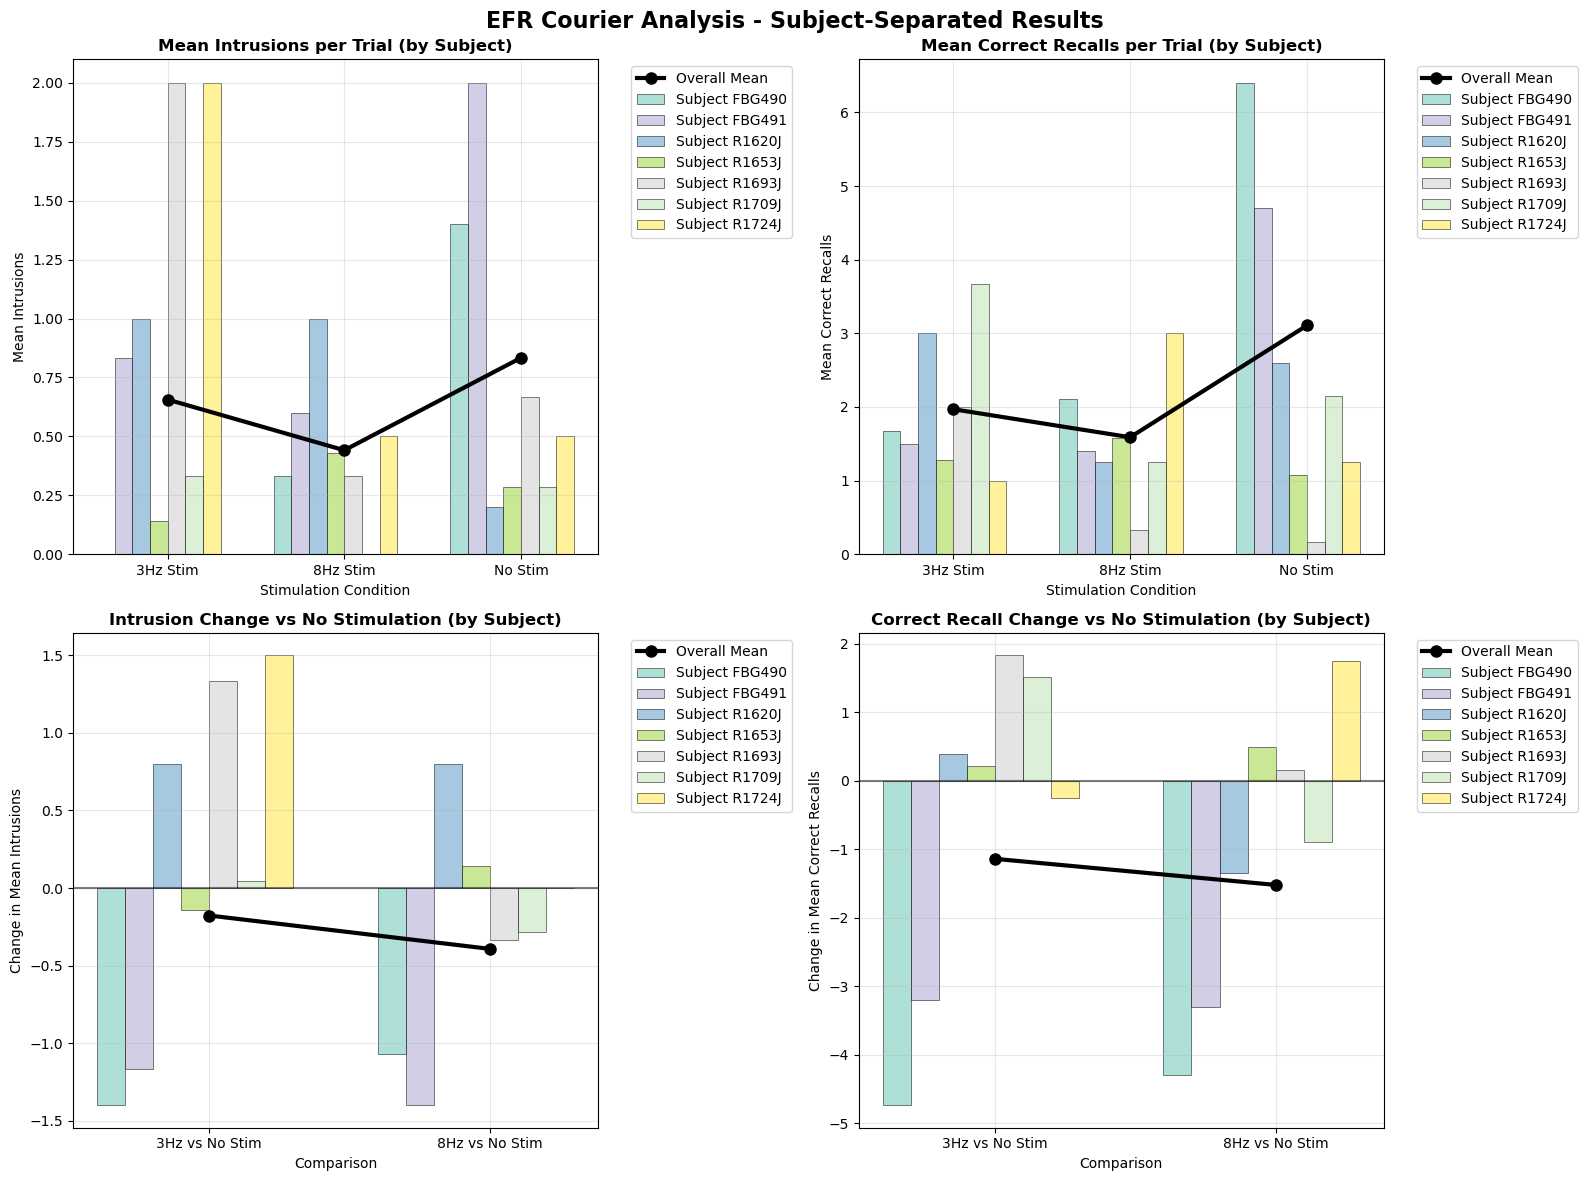


Subject-separated analysis complete!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate subject-level means
subject_means = results_df.groupby('subject').agg({
    'intrusion_count_3hz': 'mean',
    'intrusion_count_8hz': 'mean', 
    'intrusion_count_no_stim': 'mean',
    'none_intrusion_count_3hz': 'mean',
    'none_intrusion_count_8hz': 'mean',
    'none_intrusion_count_no_stim': 'mean'
}).reset_index()

# Calculate overall means (for comparison)
overall_intrusion_3hz_mean = results_df['intrusion_count_3hz'].dropna().mean()
overall_intrusion_8hz_mean = results_df['intrusion_count_8hz'].dropna().mean()
overall_intrusion_no_stim_mean = results_df['intrusion_count_no_stim'].mean()

overall_recall_3hz_mean = results_df['none_intrusion_count_3hz'].dropna().mean()
overall_recall_8hz_mean = results_df['none_intrusion_count_8hz'].dropna().mean()
overall_recall_no_stim_mean = results_df['none_intrusion_count_no_stim'].mean()

# Calculate change scores for each subject
subject_means['intrusion_change_3hz'] = subject_means['intrusion_count_3hz'] - subject_means['intrusion_count_no_stim']
subject_means['intrusion_change_8hz'] = subject_means['intrusion_count_8hz'] - subject_means['intrusion_count_no_stim']
subject_means['recall_change_3hz'] = subject_means['none_intrusion_count_3hz'] - subject_means['none_intrusion_count_no_stim']
subject_means['recall_change_8hz'] = subject_means['none_intrusion_count_8hz'] - subject_means['none_intrusion_count_no_stim']

# Set up the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('EFR Courier Analysis - Subject-Separated Results', fontsize=16, fontweight='bold')

# Colors for conditions and subjects
colors = ['#e74c3c', '#3498db', '#95a5a6']  # Red, Blue, Gray
condition_labels = ['3Hz Stim', '8Hz Stim', 'No Stim']

# Get unique subjects for plotting
subjects = subject_means['subject'].unique()
n_subjects = len(subjects)

# Create color palette for subjects
subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))

# Plot 1: Mean Intrusions per Trial (by subject)
x_positions = np.arange(len(condition_labels))
width = 0.8 / (n_subjects + 1)  # Width for each subject bar

for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    intrusion_means = [
        subject_data['intrusion_count_3hz'].iloc[0] if not pd.isna(subject_data['intrusion_count_3hz'].iloc[0]) else 0,
        subject_data['intrusion_count_8hz'].iloc[0] if not pd.isna(subject_data['intrusion_count_8hz'].iloc[0]) else 0,
        subject_data['intrusion_count_no_stim'].iloc[0]
    ]
    
    # Plot individual subject bars
    bars = ax1.bar(x_positions + (i - n_subjects/2) * width, intrusion_means, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_intrusion_means = [overall_intrusion_3hz_mean, overall_intrusion_8hz_mean, overall_intrusion_no_stim_mean]
ax1.plot(x_positions, overall_intrusion_means, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax1.set_title('Mean Intrusions per Trial (by Subject)', fontweight='bold')
ax1.set_ylabel('Mean Intrusions')
ax1.set_xlabel('Stimulation Condition')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(condition_labels)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Mean Correct Recalls per Trial (by subject)
for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    recall_means = [
        subject_data['none_intrusion_count_3hz'].iloc[0] if not pd.isna(subject_data['none_intrusion_count_3hz'].iloc[0]) else 0,
        subject_data['none_intrusion_count_8hz'].iloc[0] if not pd.isna(subject_data['none_intrusion_count_8hz'].iloc[0]) else 0,
        subject_data['none_intrusion_count_no_stim'].iloc[0]
    ]
    
    # Plot individual subject bars
    bars = ax2.bar(x_positions + (i - n_subjects/2) * width, recall_means, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_recall_means = [overall_recall_3hz_mean, overall_recall_8hz_mean, overall_recall_no_stim_mean]
ax2.plot(x_positions, overall_recall_means, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax2.set_title('Mean Correct Recalls per Trial (by Subject)', fontweight='bold')
ax2.set_ylabel('Mean Correct Recalls')
ax2.set_xlabel('Stimulation Condition')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(condition_labels)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Change in Intrusions vs No Stimulation (by subject)
x_positions_change = np.arange(2)  # 3Hz vs No Stim, 8Hz vs No Stim
change_labels = ['3Hz vs No Stim', '8Hz vs No Stim']

for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    intrusion_changes = [
        subject_data['intrusion_change_3hz'].iloc[0] if not pd.isna(subject_data['intrusion_change_3hz'].iloc[0]) else 0,
        subject_data['intrusion_change_8hz'].iloc[0] if not pd.isna(subject_data['intrusion_change_8hz'].iloc[0]) else 0
    ]
    
    # Plot individual subject bars
    bars = ax3.bar(x_positions_change + (i - n_subjects/2) * width, intrusion_changes, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_intrusion_changes = [
    overall_intrusion_3hz_mean - overall_intrusion_no_stim_mean,
    overall_intrusion_8hz_mean - overall_intrusion_no_stim_mean
]
ax3.plot(x_positions_change, overall_intrusion_changes, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax3.set_title('Intrusion Change vs No Stimulation (by Subject)', fontweight='bold')
ax3.set_ylabel('Change in Mean Intrusions')
ax3.set_xlabel('Comparison')
ax3.set_xticks(x_positions_change)
ax3.set_xticklabels(change_labels)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Change in Correct Recalls vs No Stimulation (by subject)
for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    recall_changes = [
        subject_data['recall_change_3hz'].iloc[0] if not pd.isna(subject_data['recall_change_3hz'].iloc[0]) else 0,
        subject_data['recall_change_8hz'].iloc[0] if not pd.isna(subject_data['recall_change_8hz'].iloc[0]) else 0
    ]
    
    # Plot individual subject bars
    bars = ax4.bar(x_positions_change + (i - n_subjects/2) * width, recall_changes, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_recall_changes = [
    overall_recall_3hz_mean - overall_recall_no_stim_mean,
    overall_recall_8hz_mean - overall_recall_no_stim_mean
]
ax4.plot(x_positions_change, overall_recall_changes, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax4.set_title('Correct Recall Change vs No Stimulation (by Subject)', fontweight='bold')
ax4.set_ylabel('Change in Mean Correct Recalls')
ax4.set_xlabel('Comparison')
ax4.set_xticks(x_positions_change)
ax4.set_xticklabels(change_labels)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Print subject-level statistics
print("\n" + "="*60)
print("SUBJECT-LEVEL ANALYSIS")
print("="*60)

print("\nINTRUSION MEANS BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  3Hz: {subject_data['intrusion_count_3hz'].iloc[0]:.2f}")
    print(f"  8Hz: {subject_data['intrusion_count_8hz'].iloc[0]:.2f}")
    print(f"  No Stim: {subject_data['intrusion_count_no_stim'].iloc[0]:.2f}")

print(f"\nOVERALL MEANS:")
print(f"  3Hz: {overall_intrusion_3hz_mean:.2f}")
print(f"  8Hz: {overall_intrusion_8hz_mean:.2f}")
print(f"  No Stim: {overall_intrusion_no_stim_mean:.2f}")

print("\nCORRECT RECALL MEANS BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  3Hz: {subject_data['none_intrusion_count_3hz'].iloc[0]:.2f}")
    print(f"  8Hz: {subject_data['none_intrusion_count_8hz'].iloc[0]:.2f}")
    print(f"  No Stim: {subject_data['none_intrusion_count_no_stim'].iloc[0]:.2f}")

print(f"\nOVERALL MEANS:")
print(f"  3Hz: {overall_recall_3hz_mean:.2f}")
print(f"  8Hz: {overall_recall_8hz_mean:.2f}")
print(f"  No Stim: {overall_recall_no_stim_mean:.2f}")

print("\nCHANGE SCORES BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  Intrusion Change - 3Hz vs No Stim: {subject_data['intrusion_change_3hz'].iloc[0]:.2f}")
    print(f"  Intrusion Change - 8Hz vs No Stim: {subject_data['intrusion_change_8hz'].iloc[0]:.2f}")
    print(f"  Recall Change - 3Hz vs No Stim: {subject_data['recall_change_3hz'].iloc[0]:.2f}")
    print(f"  Recall Change - 8Hz vs No Stim: {subject_data['recall_change_8hz'].iloc[0]:.2f}")

# Save the plot
plt.savefig('efr_courier_subject_separated_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as: efr_courier_subject_separated_analysis.png")

# Save subject-level results to CSV
subject_means.to_csv('efr_courier_subject_means.csv', index=False)
print(f"Subject-level results saved as: efr_courier_subject_means.csv")

plt.show()

print("\nSubject-separated analysis complete!")

In [6]:
evs

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,...,session,stim_params,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,inside_stimuli
0,8741,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.0000,-999.0000,R1724J,-999.00,-999,START,-999
1,8808,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.0000,-999.0000,R1724J,-999.00,-999,store mappings,-999
2,136651,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.0000,-999.0000,R1724J,-999.00,-999,TL_START,-999
3,136651,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-999.0000,-999.0000,R1724J,-999.00,-999,pointing begins,-999
4,142352,213.625,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.0000,-999.0000,R1724J,296.25,-999,pointing finished,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,3295080,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,0,MILK,132,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",cafe,58.3125,27.9375,R1724J,-999.00,3,REC_WORD,-999
377,3296898,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 0, 'amplitude': 0.7001953125, 'ano...",-999,-999.0000,-999.0000,R1724J,-999.00,3,STIM,-999
378,3302896,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 0, 'amplitude': 0.7001953125, 'ano...",-999,-999.0000,-999.0000,R1724J,-999.00,3,STIM,-999
379,3306564,-999.000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.0000,-999.0000,R1724J,-999.00,3,REC_STOP,-999


In [12]:
none_intrusion_events['item']

353        SUGAR
354        RAZOR
355    HULA_HOOP
357        PIPES
358        PIPES
362        WATCH
364        WATCH
374         MILK
376         MILK
Name: item, dtype: object